## Import packages and data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Display figures as svg in notebook (improves resolution)
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

# Import the data
houses = pd.read_csv("../data/King_County_House_prices_dataset.csv") # ../ jumps up one level in the directory

### District - zipcode mapping
Code and file friendly borrowed by Torben L.

In [2]:
#new dataframe for districts
zipcodes_districts = pd.read_csv('../data/zipcodes.csv')
irrcolumns = ['Zipcode name', 'State', 'County Name']
districtsdf = zipcodes_districts.drop(irrcolumns, 1) #probably not necessary
districtsdf = districtsdf.rename(columns={'zip': 'zipcode'})
districtsdf.zipcode = districtsdf.zipcode.astype(int) #convert datatype
houses = pd.merge(houses, districtsdf, on = ['zipcode'], suffixes = ['a', 'b'])

/var/folders/53/gg42r53n4gqf4gxqzfcm5gcm0000gn/T/ipykernel_3088/665217305.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  districtsdf = zipcodes_districts.drop(irrcolumns, 1) #probably not necessary


## House location maps sorted by waterfront status
Many houses that are classified as "not on waterfront" or "waterfront unknown" appear to be on the shoreline. However, zooming into the map reveals that most if not all of these houses are, e.g., part of a housing block and facing away from the water. Thus, I label all houses with unknown waterfront as "not on waterfront".

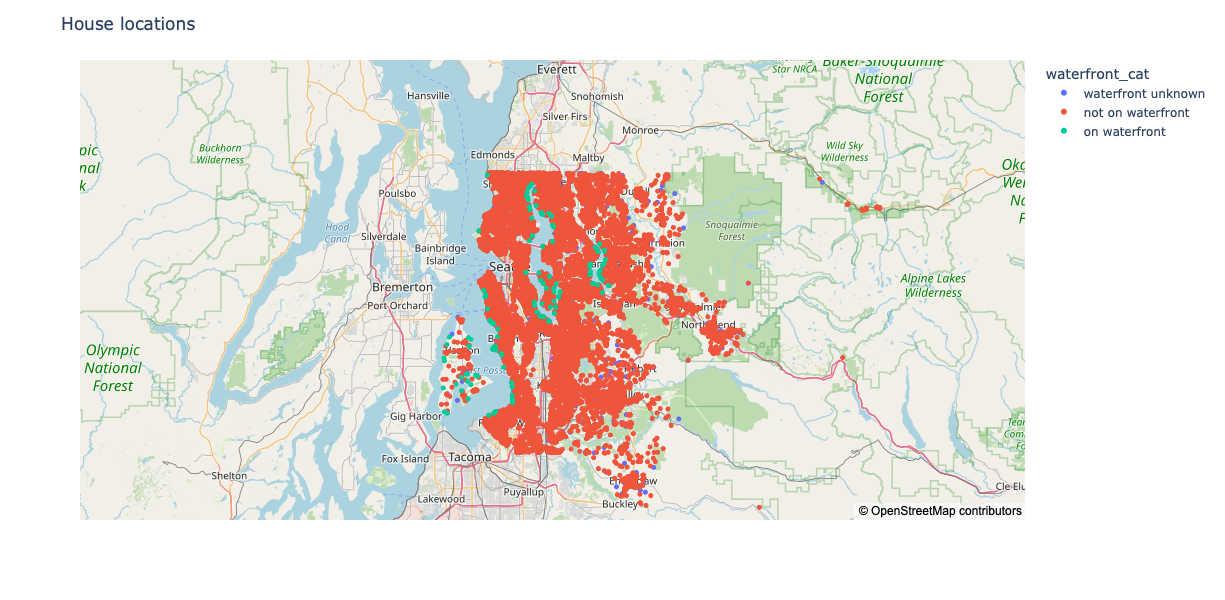

In [3]:
# Plotting houses on the map
houses["waterfront"] = houses["waterfront"].fillna(2)
houses["waterfront_cat"] = houses.waterfront.astype(str)

houses.waterfront_cat.replace(["0.0","1.0","2.0"],["not on waterfront","on waterfront","waterfront unknown"], inplace=True)

fig = px.scatter_mapbox(houses, lat="lat", lon="long", hover_name="id" , color="waterfront_cat")
fig.update_layout(mapbox_style="open-street-map", title="House locations",              
    autosize=False,width=600,height=600)
fig.update_geos(fitbounds="locations")
fig.show()

# Relabel waterfront = NA as not on waterfront
houses.waterfront_cat.replace("waterfront unknown","not on waterfront", inplace=True)
houses.waterfront.replace(2,0, inplace=True)

## Strict house selection based on stakeholder profile
The stakeholder looks for a renovated house on the waterfront "to show off" with. Price is not an issue. I filter the data by waterfront and renovation status and look at the variables price, grade, living area size and number of bedrooms to identify nice properties. Furthermore, I also take a look at how the renovated waterfront houses do in comparison with the full county data and other houses in the same zipcode areas.

In [4]:
# Houses with yr_renovated = NAN are treated as if they were never renovated
houses["yr_renovated"] = houses["yr_renovated"].fillna(0)

# Selecting renovated houses on the waterfront
houses_sub = houses[(houses.waterfront==1) & (houses.yr_renovated>0)].reset_index()

# Key variable values relative to the county median
houses_sub["price_dmedian"]       = houses_sub.price - houses.price.median()
houses_sub["grade_dmedian"]       = houses_sub.grade - houses.grade.median()
houses_sub["sqft_living_dmedian"] = houses_sub.sqft_living - houses.sqft_living.median()
houses_sub["bedrooms_dmedian"]    = houses_sub.bedrooms - houses.bedrooms.median()

# Median key variable values per zipcode for selected houses
per_zip_means = houses.groupby("zipcode").median().reset_index()
per_zip_means = per_zip_means[["zipcode","price","bedrooms","sqft_living","grade"]]

houses_sub = houses_sub.merge(per_zip_means, on='zipcode', suffixes=("","_median_zip"))

# Key variable values relative to the zipcode median
houses_sub["price_dmedian_zip"]       = houses_sub.price - houses_sub.price_median_zip
houses_sub["grade_dmedian_zip"]       = houses_sub.grade - houses_sub.grade_median_zip
houses_sub["sqft_living_dmedian_zip"] = houses_sub.sqft_living - houses_sub.sqft_living_median_zip
houses_sub["bedrooms_dmedian_zip"]    = houses_sub.bedrooms - houses_sub.bedrooms_median_zip

### Price, grade, living area size and number of bedrooms relative to the county and zipcode median

In [ ]:
keyvars = ["price_dmedian","grade_dmedian","sqft_living_dmedian","bedrooms_dmedian"]
rcidx = [(1,1),(1,2),(2,1),(2,2)]

for i in range(2):
    if i==0:
        ysuf = ""
        bigtitle = "Key variables relative to county median"
        fname = "../figures/keyvars_rel2countymedian.png"
    else:
        ysuf = "_zip"
        bigtitle = "Key variables relative to zipcode median"
        fname = "../figures/keyvars_rel2zipmedian.png"
        
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Price ($)", "Grade", "Living area (sqare feet)", "Number of bedrooms"))
    
    for i,idx in enumerate(rcidx):
        fig.add_trace(go.Scatter(x=houses_sub.index.astype(str), y=houses_sub[keyvars[i]+ysuf],
                        mode="markers"),row=idx[0], col=idx[1])

    fig.update_layout(autosize=False,width=800,height=600,template="plotly_white", showlegend=False, title_text=bigtitle, title_x=0.5)
    fig.show()
    fig.write_image(fname,scale=5)

### Relationship between key variables

In [ ]:
for i in range(3):
    if i==0:
        ttl = "All renovated waterfront houses"
        houses_sub2 = houses_sub
        fname = "../figures/renovated_waterfront_houses.png"
    elif i==1:
        ttl = "Houses above county median"
        houses_sub2 = houses_sub.query(
            "bedrooms_dmedian >0 and sqft_living_dmedian >0 and grade_dmedian >0")
        fname = "../figures/renovated_waterfront_houses_above_countymedian.png"
    else:
        ttl = "Houses above zipcode median"
        houses_sub2 = houses_sub.query(
            "bedrooms_dmedian_zip >0 and sqft_living_dmedian_zip >0 and grade_dmedian_zip >0")
        fname = "../figures/renovated_waterfront_houses_above_zipmedian.png"
    
    fig = px.scatter(houses_sub2, x="bedrooms", y="price", color="grade", size='sqft_living', hover_data=["id"],
                    labels={"price": "Price ($)","bedrooms": "Number of bedrooms","grade": "Grade"})
    fig.update_layout(autosize=False,width=400,height=400,template="plotly_white", title_text=ttl, title_x=0.5)
    fig.update_xaxes(range=(1.5,6.5)) 
    fig.update_yaxes(range=(0,8000000)) 
    fig.show()
    fig.write_image(fname,scale=5)



### House locations on the map

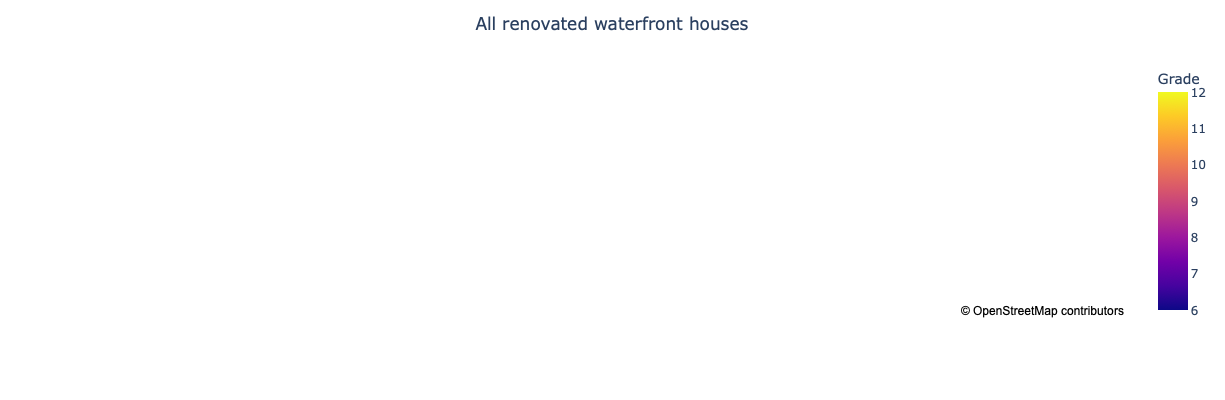

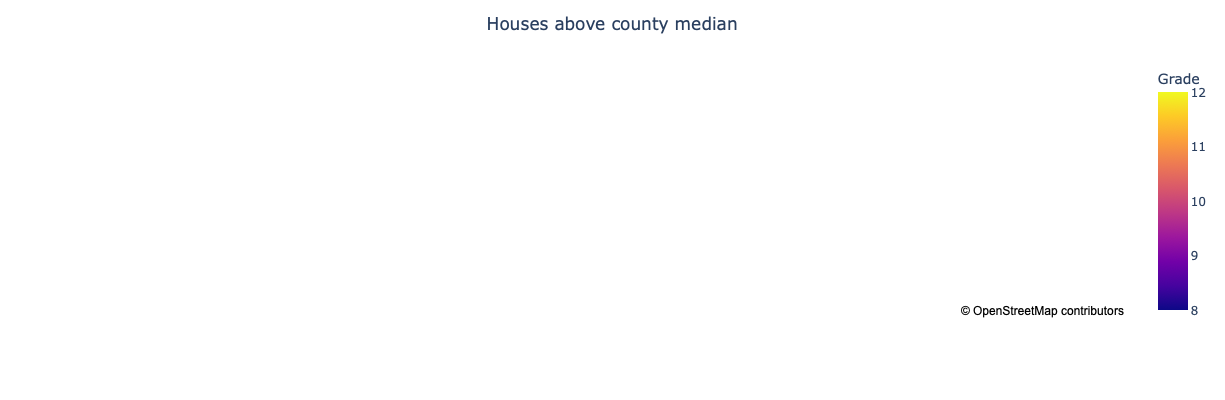

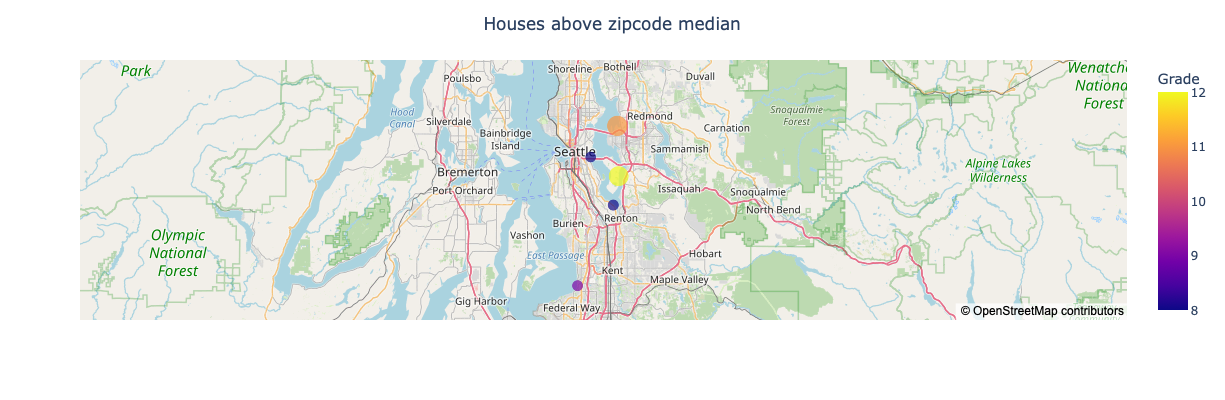

In [17]:
for i in range(3):
    if i==0:
        ttl = "All renovated waterfront houses"
        houses_sub2 = houses_sub
        fname = "../figures/renovated_waterfront_houses_MAP.png"
    elif i==1:
        ttl = "Houses above county median"
        houses_sub2 = houses_sub.query(
            "bedrooms_dmedian >0 and sqft_living_dmedian >0 and grade_dmedian >0")
        fname = "../figures/renovated_waterfront_houses_above_countymedian_MAP.png"
    else:
        ttl = "Houses above zipcode median"
        houses_sub2 = houses_sub.query(
            "bedrooms_dmedian_zip >0 and sqft_living_dmedian_zip >0 and grade_dmedian_zip >0")
        fname = "../figures/renovated_waterfront_houses_above_zipmedian_MAP.png"
    
    fig = px.scatter_mapbox(houses_sub2, lat="lat", lon="long", hover_name="id" , color="grade",
                            size="sqft_living", size_max=15,
                           labels={"grade": "Grade"})
    fig.update_layout(mapbox_style="open-street-map", title=ttl, title_x=0.5,
        autosize=False,width=400,height=400)
    fig.update_geos(fitbounds="locations")
    fig.show()
    fig.write_image(fname,scale=5)
